In [1]:
push!(LOAD_PATH, "..")
using ASE
using PyPlot
using PyCall

INFO: Recompiling stale cache file /Users/ortner/.julia/lib/v0.4/PyPlot.ji for module PyPlot.
INFO: Recompiling stale cache file /Users/ortner/.julia/lib/v0.4/Colors.ji for module Colors.
INFO: Recompiling stale cache file /Users/ortner/.julia/lib/v0.4/FixedPointNumbers.ji for module FixedPointNumbers.
INFO: Recompiling stale cache file /Users/ortner/.julia/lib/v0.4/ColorTypes.ji for module ColorTypes.
INFO: Recompiling stale cache file /Users/ortner/.julia/lib/v0.4/Reexport.ji for module Reexport.
INFO: Recompiling stale cache file /Users/ortner/.julia/lib/v0.4/LaTeXStrings.ji for module LaTeXStrings.
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at /Applications/Julia-0.4.0-rc2.app/Contents/Resources/julia/lib/julia/sys.dylib
 in include_from_node1 at /Applications/Julia-0.4.0-rc2.app/Contents/Resources/julia/lib/julia/sys.dylib
 [inlined code] from none:2
 in anonymous at no file:0
 in process_options at /Applications/Julia-0.4.0-rc2.app/Contents/Resources

In [4]:
at = bulk("Al")
at = repeat(at, (5, 5, 5))
X = get_positions(at)
nlist = ASENeighborList(at, 1.5; self_interaction=false, bothways=true)


ASE.ASENeighborList(PyObject <ase.calculators.neighborlist.NeighborList instance at 0x319c51680>)

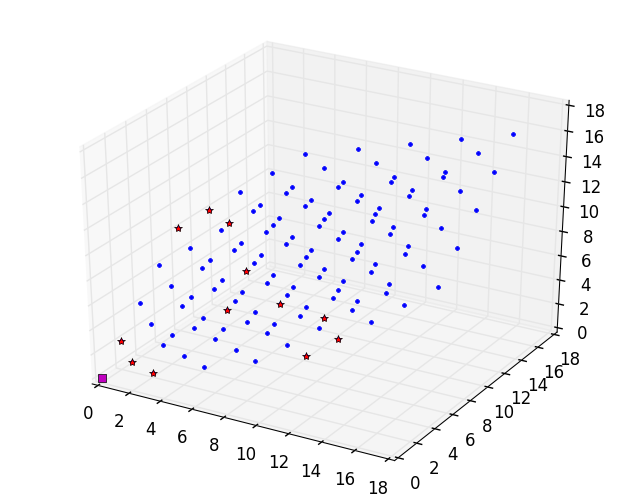

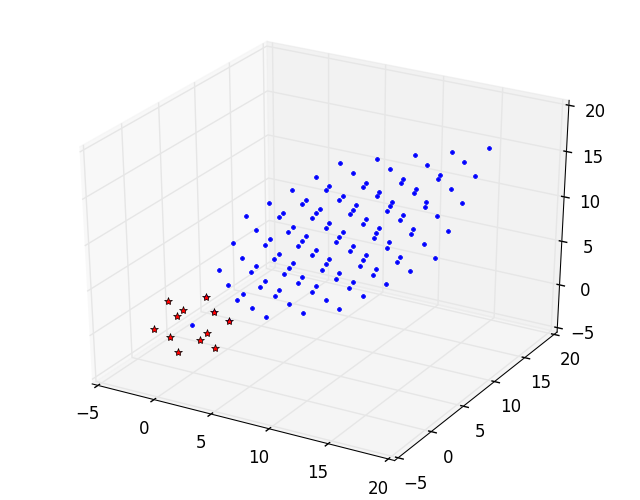

1-element Array{Any,1}:
 PyObject <mpl_toolkits.mplot3d.art3d.Line3D object at 0x31acce990>

In [7]:

figure(1)
I, _ = get_neighbors(1, nlist)
plot3D(X[1,:][:], X[2,:][:], X[3,:][:], "b.")
plot3D(X[1,I][:], X[2,I][:], X[3,I][:], "r*")
plot3D([X[1,1];], [X[2,1];], [X[3,1];], "ms")

figure(2)
I, _, r = neighbors(1, nlist, at)
plot3D(X[1,:][:], X[2,:][:], X[3,:][:], "b.")
r .+= X[:,1]
plot3D(slice(r, 1,:), slice(r,2,:), slice(r,3,:), "r*")



 # Some Benchmarking

In [1]:
push!(LOAD_PATH, "..")
using ASE
using ProfileView

function loop_neigs(at, nlist)
    for n = 1:length(at)
        I, s, r = neighbors(n, nlist, at)
    end
end

function loop_neigs2(at, nlist)
    for (n, I, s, r) in (at, nlist)
        nothing
    end
end

at = bulk("Al")
at = repeat(at, (8, 8, 8))
nlist = ASENeighborList(at, 1.5; self_interaction=false, bothways=true)


@time loop_neigs(at, nlist)
@time loop_neigs(at, nlist)
@time loop_neigs2(at, nlist)
@time loop_neigs2(at, nlist)



4.685667 seconds (5.83 M allocations: 347.768 MB, 1.99% gc time)
  1.144506 seconds (243.23 k allocations: 9.641 MB, 0.57% gc time)
  0.564588 seconds (158.08 k allocations: 6.930 MB)
  

In [ ]:
Profile.clear()
@profile loop_neigs2(at, nlist)


In [ ]:
ProfileView.view()


In [16]:
using PyCall


In [92]:
# Standard call: 0.356330 seconds (89.00 k allocations: 3.258 MB)
@time for n = 1:500 I, off = nlist.po[:get_neighbors](0); end   
# get a tuple of PyArrays: 0.379282 seconds (62.00 k allocations: 2.022 MB)
@time for n = 1:500 ret = pycall(nlist.po[:get_neighbors], Tuple{PyArray, PyArray}, 0); end
# just get a PyObject: 0.039529 seconds (9.50 k allocations: 273.438 KB)
#    with lines 2-3 uncommented: 0.101147 seconds (28.50 k allocations: 820.313 KB)
@time for n = 1:500 begin 
        ret = pycall(nlist.po[:get_neighbors], PyObject, 0); end
        # ret1 = pycall(ret[:__getitem__], PyObject, 0)
        # ret2 = pycall(ret[:__getitem__], PyObject, 1)
end
nothing

  0.414566 seconds (89.00 k allocations: 3.258 MB)
  0.430945 seconds (62.00 k allocations: 2.022 MB, 4.86% gc time)
  0.101147 seconds (28.50 k allocations: 820.313 KB)


In [90]:
ret = pycall(nlist.po[:get_neighbors], PyObject, 0);
typeof(ret)

PyCall.PyObject

In [81]:
# pytypeof(ret1)


PyObject <type 'numpy.ndarray'>

LoadError: LoadError: KeyError: first not found
while loading In[70], in expression starting on line 1